In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto   
config.log_device_placement = True
sess = tf.compat.v1.Session()

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import numpy as np
from scipy import misc
from keras.models import load_model
%matplotlib inline

In [3]:
# defining the path for datasets.
training_dataset = 'training'
testing_dataset = 'testing'
# define classes
# d - drinking activity, i - idling activity, l - laptop using activity, p - phone using activity, w - writing activity
classes = ['d','i','l','p','w']

[[215 215 214 ... 231 231 233]
 [215 215 214 ... 231 231 233]
 [215 215 214 ... 233 233 234]
 ...
 [185 185 185 ... 215 215 215]
 [185 185 185 ... 218 218 218]
 [185 185 185 ... 219 219 219]]


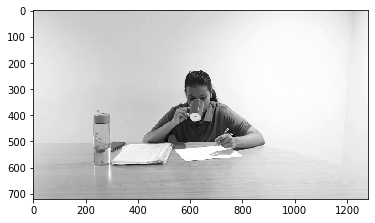

In [4]:
# display training data
for cls in classes:
    path = os.path.join(training_dataset,cls)

    for img in os.listdir(path):
        imgPath = os.path.join(path,img)
        imgArray = cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE)
        print(imgArray)
        plt.imshow(imgArray, cmap='gray')
        plt.show()
        break
    break

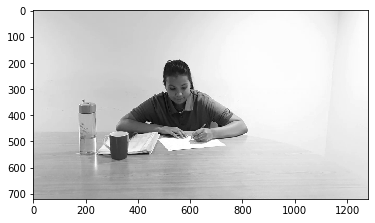

In [5]:
# display testing data
testArray = []
for img in os.listdir(testing_dataset):
    imgArray = cv2.imread(os.path.join(testing_dataset,img),cv2.IMREAD_GRAYSCALE)
    testArray = imgArray
    plt.imshow(imgArray, cmap='gray')
    plt.show()
    break

In [6]:
# displaying shape of the images.
print(imgArray.shape)

(720, 1280)


In [7]:
# defining the image sizes
imgSize1 = 240
imgSize2 = 240

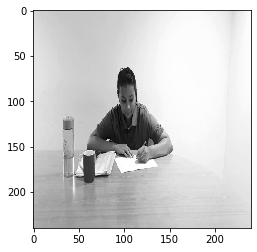

In [8]:
# resizing the images
newImg = cv2.resize(testArray,(imgSize1,imgSize2))
plt.imshow(newImg,cmap='gray')
plt.show()

In [9]:
# generating training dataset with new sizes.
training_data = []

def createTrainingDataset():
    for category in classes:
        path = os.path.join(training_dataset,category)
        NoOfClasses = classes.index(category)
        
        for img in os.listdir(path):
            imgArray = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
            newImg = cv2.resize(imgArray,(imgSize1,imgSize2))
            training_data.append([
                newImg,NoOfClasses])

In [10]:
# generating testing dataset with new sizes.
testing_data = []

def createTestingDataset():        
    for img in os.listdir(testing_dataset):
        imgArray = cv2.imread(os.path.join(testing_dataset,img),cv2.IMREAD_GRAYSCALE)
        newImg = cv2.resize(imgArray,(imgSize1,imgSize2))
        testing_data.append([img,
            newImg])

In [11]:
createTrainingDataset()

In [12]:
createTestingDataset()

In [13]:
print(len(training_data))
print(len(testing_data))

201
402


In [14]:
random.shuffle(training_data)

In [15]:
x = []
y = []

In [16]:
for features, label in training_data:
    x.append(features)
    y.append(label)

In [17]:
x[0].shape

(240, 240)

In [18]:
len(x)

201

In [19]:
len(y)

201

In [20]:
X = np.array(x).reshape(-1,imgSize1,imgSize2,1)
X[0].shape

(240, 240, 1)

In [21]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=50)

In [22]:
Y_train = np_utils.to_categorical(y_train,num_classes=5)
Y_test = np_utils.to_categorical(y_test,num_classes=5)

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(240,240,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))

In [25]:
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))

In [26]:
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.5))

In [27]:
model.add(Flatten())
model.add(Dense(units = 512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = 128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 238, 238, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 238, 238, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 238, 238, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 238, 238, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 119, 119, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 119, 119, 64)     

In [29]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [30]:
callbacks = [EarlyStopping(monitor='val_accuracy',patience=5)]

In [31]:
batch_size = 50
n_epochs = 20

In [32]:
results = model.fit(x_train,Y_train,batch_size=batch_size,epochs=n_epochs,verbose=1,validation_data=(x_test,Y_test),callbacks=callbacks)

Train on 140 samples, validate on 61 samples
Epoch 1/20
140/140 [==============================] - 136s 968ms/step - loss: 1.9893 - accuracy: 0.4286 - val_loss: 37.2529 - val_accuracy: 0.4098
Epoch 2/20
140/140 [==============================] - 116s 832ms/step - loss: 0.3270 - accuracy: 0.9286 - val_loss: 37.7854 - val_accuracy: 0.2787
Epoch 3/20
140/140 [==============================] - 111s 796ms/step - loss: 0.1261 - accuracy: 0.9643 - val_loss: 34.6351 - val_accuracy: 0.2787
Epoch 4/20
140/140 [==============================] - 101s 720ms/step - loss: 0.1520 - accuracy: 0.9500 - val_loss: 29.8955 - val_accuracy: 0.3770
Epoch 5/20
140/140 [==============================] - 101s 720ms/step - loss: 0.0903 - accuracy: 0.9714 - val_loss: 26.4288 - val_accuracy: 0.4426
Epoch 6/20
140/140 [==============================] - 109s 775ms/step - loss: 0.0655 - accuracy: 0.9786 - val_loss: 23.9155 - val_accuracy: 0.4426
Epoch 7/20
140/140 [==============================] - 100s 715ms/step - l

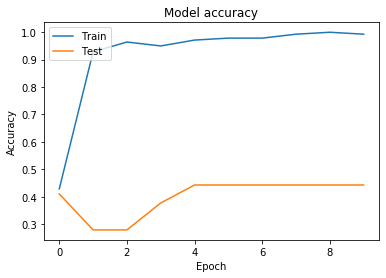

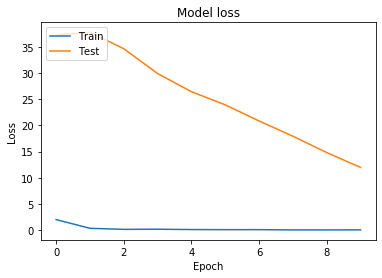

In [33]:
# model accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# model loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
predection = model.predict(np.array(testing_data[0][1]).reshape(-1,imgSize1,imgSize2,1))

In [35]:
model.save_weights('./activity-recognition.h5', overwrite=True)

In [36]:
model.save('./activity-recognition.h5')

In [37]:
loaded_model = load_model('activity-recognition.h5')

In [38]:
test_data = np.array(testing_data[100][1]).reshape(-1,imgSize1,imgSize2,1)

In [39]:
predection = loaded_model.predict(test_data)
predection

array([[1.0000000e+00, 1.1079903e-09, 1.2251178e-08, 4.2359487e-15,
        4.9041847e-13]], dtype=float32)

Activity: 0


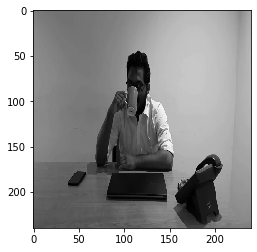

In [40]:
print('Activity: {}'.format(np.argmax(predection)))
newImg = cv2.resize(testing_data[100][1],(imgSize1,imgSize2))
plt.imshow(newImg,cmap='gray')
plt.show()